<a href="https://colab.research.google.com/github/amitshakarchy/big-data-analysis/blob/main/HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Amit Shakarchy

Github link: https://github.com/amitshakarchy/big-data-analysis

# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [26]:
!mkdir datasets
!mkdir datasets/PypiDependencies
!wget http://kgullikson88.github.io/blog/Downloads/PypiDependencies/requirements.csv -P datasets/PypiDependencies
!ls datasets/PypiDependencies

mkdir: cannot create directory ‘datasets’: File exists
mkdir: cannot create directory ‘datasets/PypiDependencies’: File exists
--2021-11-24 14:12:59--  http://kgullikson88.github.io/blog/Downloads/PypiDependencies/requirements.csv
Resolving kgullikson88.github.io (kgullikson88.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to kgullikson88.github.io (kgullikson88.github.io)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4933296 (4.7M) [text/csv]
Saving to: ‘datasets/PypiDependencies/requirements.csv.2’

requirements.csv.2  100%[===================>]   4.70M  --.-KB/s    in 0.08s   

2021-11-24 14:12:59 (57.5 MB/s) - ‘datasets/PypiDependencies/requirements.csv.2’ saved [4933296/4933296]

requirements.csv  requirements.csv.1  requirements.csv.2


In [28]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:

CSV_PATH = '/content/datasets/PypiDependencies/requirements.csv'

df = pd.read_csv(CSV_PATH)
df.head()

,package,requirement,package_name,package_version
0,02exercicio-1.0.0,NaN,02exercicio,1.0.0
1,0x10c-asm-0.0.2,NaN,0x10c-asm,0.0.2
2,115wangpan-0.7.6,beautifulsoup4,115wangpan,0.7.6
3,115wangpan-0.7.6,homura,115wangpan,0.7.6
4,115wangpan-0.7.6,humanize,115wangpan,0.7.6


In [48]:
df = df.sample(frac=0.4, random_state=1) # I sample 0.6 of the dataframe so the code wont stuck

In [59]:
# Now, I'll create a graph out of the edges using networkx
ng = nx.DiGraph()
ng = nx.from_pandas_edgelist(df, 'package_name', 'requirement')
nx.info(ng)

'Graph with 10266 nodes and 10504 edges'

In [32]:
# Develop a simple link prediction classifier based on the network's directed topology (40pt)
import random 

def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links and u == v:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)

# create positive and negative samples
postive_links = select_random_existing_links(ng,100)
negative_links = select_random_non_existing_links(ng,100)
print(len(negative_links))

100


In [33]:
!pip install tqdm
from tqdm import tqdm_notebook as tqdm 

In [34]:
import operator
def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set


def rank_friends_of_friends(g, v):
    rank_dict = {}
    vertices_set = find_friends_of_friends(g, v)
    for u in vertices_set:
        rank_dict[u] = len(common_friends(g, v, u))
    sorted_d = sorted(rank_dict.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_d

# rank_friends_of_friends(ng, '02exercicio-1.0.0')

In [ ]:
def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            'jaccard_coefficient': list(nx.jaccard_coefficient(g,[(u,v)]))[0][2],
            'adamic_adar_index': list(nx.adamic_adar_index(g,[(u,v)]))[0][2],
            'friends_measure': friends_measure(g, u,v)
        }
    except:
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(ng, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(ng, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)
links_features[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

{'adamic_adar_index': 0,
 'class': True,
 'common_friends': 0,
 'degree_u': 21772,
 'degree_v': 0,
 'friends_measure': 0,
 'jaccard_coefficient': 0.0,
 'total_friends': 21772}

In [35]:
!pip install turicreate

In [38]:
import turicreate as tc
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'jaccard_coefficient', 'adamic_adar_index', 'friends_measure', 'class' ]
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)


In [ ]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'jaccard_coefficient', 'adamic_adar_index', 'friends_measure' ]
cls = tc.classifier.create(train,features=features_list, target="class")
cls

Train size 166
Test size: 34
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 157

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.001922     | 0.974522          | 1.000000            | 0.480489          | 0.457704            |

| 2         | 0.003236     | 0.974522          | 1.000000            | 0.349667          | 0.321368            |

| 3         | 0.004309     | 0.987261          | 1.000000            | 0.265998          | 0.233965            |

| 4         | 0.005429     | 0.974522          | 1.000000            | 0.213265          | 0.175252            |

| 5         | 0.006799     | 0.987261          | 1.000000            | 0.172629          | 0.133498            |

| 10        | 0.015542     | 0.987261          | 1.000000            | 0.090851          | 0.045808            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 157

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.007703     | 0.955414          | 1.000000            | 0.246782          | 0.160373            |

| 2         | 0.008881     | 0.942675          | 1.000000            | 0.250415          | 0.161076            |

| 3         | 0.011185     | 0.942675          | 1.000000            | 0.237946          | 0.156521            |

| 4         | 0.013320     | 0.961783          | 1.000000            | 0.236998          | 0.157066            |

| 5         | 0.015568     | 0.961783          | 1.000000            | 0.236593          | 0.156361            |

| 10        | 0.025433     | 0.961783          | 1.000000            | 0.227609          | 0.155562            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 157

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.003387     | 0.974522          | 1.000000            | 0.209145          | 0.151457            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 157

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients    : 8

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.000522     | 0.547771          | 0.555556            |

| 1         | 4        | 1.000000  | 0.001977     | 0.547771          | 0.555556            |

| 2         | 5        | 1.000000  | 0.005035     | 0.764331          | 0.777778            |

| 3         | 6        | 1.000000  | 0.008650     | 0.751592          | 0.666667            |

| 4         | 8        | 1.000000  | 0.009312     | 0.783439          | 0.777778            |

| 9         | 24       | 0.230584  | 0.015231     | 0.783439          | 0.777778            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 157

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients      : 8

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.001029     | 0.802548          | 0.777778            |

| 2         | 3        | 0.002805     | 0.808917          | 0.777778            |

| 3         | 4        | 0.003716     | 0.821656          | 0.777778            |

| 4         | 5        | 0.005098     | 0.840764          | 0.777778            |

| 5         | 6        | 0.006299     | 0.859873          | 0.777778            |

| 8         | 9        | 0.009327     | 0.878981          | 0.777778            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 1.0
PROGRESS: RandomForestClassifier          : 1.0
PROGRESS: DecisionTreeClassifier          : 1.0
PROGRESS: SVMClassifier                   : 0.7777777777777778
PROGRESS: LogisticClassifier              : 0.7777777777777778
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


Class                          : BoostedTreesClassifier

Schema
------
Number of examples             : 157
Number of feature columns      : 7
Number of unpacked features    : 7
Number of classes              : 2

Settings
--------
Number of trees                : 10
Max tree depth                 : 6
Training time (sec)            : 0.0213
Training accuracy              : 0.9873
Validation accuracy            : 1.0
Training log_loss              : 0.0909
Validation log_loss            : 0.0458
Training auc                   : 0.9912
Validation auc                 : 1.0

In [ ]:
results = cls.evaluate(test)
results

{'accuracy': 0.9705882352941176,
 'auc': 0.992982456140351,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 3
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        0        |   19  |
 |      1       |        0        |   1   |
 |      1       |        1        |   14  |
 +--------------+-----------------+-------+
 [3 rows x 3 columns],
 'f1_score': 0.9655172413793104,
 'log_loss': 0.13340482894365643,
 'precision': 1.0,
 'recall': 0.9333333333333333,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+-----+-----+----+----+
 | threshold | fpr | tpr | p  | n  |
 +-----------+-----+-----+----+----+
 |    0.0    | 1.0 | 1.0 | 15 | 19 |
 |   0.001   | 1.0 | 1.0 | 15 | 19 |
 |   0.002   | 1.0 | 1.0 | 15 | 19 |
 |   0.003   | 1.0 | 1.0 | 15 | 19 |
 |   0.004   | 1.0 | 1.0 |

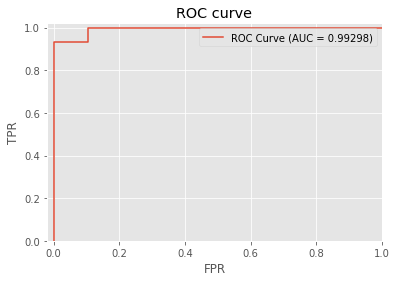

In [ ]:
plt.style.use('ggplot')
plt.plot(results['roc_curve']['fpr'],
         results['roc_curve']['tpr'],
         label='ROC Curve (AUC = %0.5f)' %results['auc'])

plt.xlim([-0.02, 1.0])
plt.ylim([0., 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

In [39]:
# Use node or link embedding features and try to improve the classification (20pt)
!pip install karateclub
import karateclub

In [92]:
l =  zip(ng.nodes(), range(len(ng.nodes())))
l = list(l)
l[:10]

[('KloudBuster', 0),
 ('hdrhistogram', 1),
 ('asyncio-throttler', 2),
 (nan, 3),
 ('UW-RestClients', 4),
 ('django', 5),
 ('Satchmo', 6),
 ('text', 7),
 ('Flask-RESTful', 8),
 ('blinker', 9)]

In [93]:
nodes_dict = dict(l)
r_node_dict = {v:k for k,v in nodes_dict.items()}
list(r_node_dict.items())[:10]

[(0, 'KloudBuster'),
 (1, 'hdrhistogram'),
 (2, 'asyncio-throttler'),
 (3, nan),
 (4, 'UW-RestClients'),
 (5, 'django'),
 (6, 'Satchmo'),
 (7, 'text'),
 (8, 'Flask-RESTful'),
 (9, 'blinker')]

In [94]:
h = nx.Graph()
for e1,e2 in ng.edges():
  h.add_edge(nodes_dict[e1], nodes_dict[e2])
print(nx.info(ng))
print(nx.info(h))

Graph with 10266 nodes and 10504 edges
Graph with 10266 nodes and 10504 edges


In [68]:
model = karateclub.DeepWalk()

model.fit(h)
embedding = model.get_embedding()
embedding

array([[-0.3048629 ,  0.20477293,  0.25987563, ..., -0.34134263,
         0.44529867, -0.21815601],
       [-1.7185838 ,  1.2258787 ,  1.4244676 , ..., -1.9167985 ,
         2.4519684 , -1.2939229 ],
       [-0.2465284 ,  0.14919744,  0.18853287, ..., -0.2420481 ,
         0.2871491 , -0.18643862],
       ...,
       [ 0.02386476,  0.57843786,  0.13865453, ..., -1.4238942 ,
         0.39374676, -0.4034971 ],
       [-0.3506182 , -0.3688548 ,  0.90971637, ..., -0.6962723 ,
         0.8802278 , -0.620196  ],
       [-0.35691077, -0.45296985,  0.01871785, ..., -0.77582383,
         0.8778808 ,  0.40094993]], dtype=float32)

In [95]:
# create positive & negative samples

postive_links = select_random_existing_links(ng,100)
negative_links = select_random_non_existing_links(ng,100)
print(len(negative_links))

100


In [80]:
def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

In [102]:
embedding[nodes_dict["hdrhistogram"]]

array([-1.7185838 ,  1.2258787 ,  1.4244676 ,  2.2383635 , -0.76529056,
       -0.742696  , -1.3531052 ,  0.40808982, -1.3895098 ,  1.7252601 ,
        0.8304468 ,  1.6118064 , -0.20906313,  1.60308   , -2.0641313 ,
       -0.3361002 ,  0.5547705 , -0.00545438,  1.1866878 , -2.1959512 ,
        1.6286871 , -1.5817947 , -1.7652119 , -0.22884819,  1.483848  ,
       -0.815404  ,  1.8126577 , -1.324836  ,  1.436435  , -1.8107549 ,
        1.0437981 ,  1.1500489 , -2.0171568 ,  1.4691404 ,  0.54032415,
       -0.0478643 ,  1.9638305 ,  1.6428792 , -0.7300692 ,  2.0012023 ,
        1.8225157 , -1.6805547 ,  0.5877654 ,  1.7770834 , -1.983931  ,
       -2.2325203 ,  1.1868498 , -1.9407089 , -0.8965239 , -0.42659268,
        1.7053275 ,  0.8933331 , -1.0431485 , -0.08365252, -0.18150051,
       -1.5194194 , -0.17245752,  0.7588977 , -1.8090649 ,  1.7679946 ,
        0.9861567 ,  1.3980876 ,  0.02826006, -1.047749  ,  0.9856363 ,
        2.0801837 , -1.7604727 , -0.7012018 ,  2.2270455 ,  2.01

In [103]:
def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        # print(embedding[r_node_dict[v]])
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            'friends_measure': friends_measure(g, u,v),
             'embed_v': embedding[nodes_dict[v]],
             'embed_u': embedding[nodes_dict[u]],
        }
    except:
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    # print(nodes_dict)
    # print(embedding[nodes_dict[v]])
    d = get_features_dict(ng, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(ng, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

In [104]:
links_features[0]

{'class': True,
 'common_friends': 0,
 'degree_u': 33,
 'degree_v': 0,
 'embed_u': array([-1.24407381e-01,  1.20291121e-01,  2.28770062e-01,  1.09434575e-02,
        -4.76704352e-02, -7.73082897e-02,  2.34076660e-02,  1.17245510e-01,
        -1.16983503e-01,  6.04972988e-02,  5.80110997e-02,  1.20682258e-03,
        -1.03760637e-01,  1.07615069e-01, -2.55016446e-01,  3.73589545e-01,
         1.11448459e-01, -2.35913042e-03, -3.01439315e-03, -1.94416627e-01,
         1.21154308e-01, -9.64431614e-02, -1.17317647e-01, -7.23466873e-02,
         2.13193208e-01,  2.58133225e-02,  4.04432595e-01, -1.89557523e-01,
         4.21495400e-02, -5.34258723e-01,  1.38671100e-01, -4.58211228e-02,
        -2.98235148e-01,  2.45853364e-01,  5.56126498e-02,  3.12530920e-02,
         4.80944276e-01,  1.81099162e-01, -1.44266024e-01,  3.07673931e-01,
         2.06493944e-01, -6.77911490e-02,  7.62389228e-02,  1.09656274e-01,
        -8.03889334e-03, -2.10504718e-02,  1.37387916e-01, -6.95301145e-02,
      

In [105]:

import turicreate as tc

features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'friends_measure', 'embed_v', 'embed_u','class']
data_dict = {f:[] for f in features_list}
 
for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf

class,common_friends,degree_u,degree_v,embed_u,embed_v,friends_measure
1,0,33,0,[-1.24407381e-011.20291121e-01 ...,[ 6.07721150e-011.34634769e+00 ...,0
1,0,3477,0,[-0.61901015 0.265129890.32381636 0.47614625 ...,[-0.15251599 0.428784520.79482794 1.30476892 ...,0
1,0,3477,0,[-0.61901015 0.265129890.32381636 0.47614625 ...,[-0.55179316 0.240211280.93100494 1.28864777 ...,0
1,0,3477,0,[-0.61901015 0.265129890.32381636 0.47614625 ...,[-0.94695467 0.54186058-0.01524638 1.68195879 ...,0
1,0,1,0,[-0.03537966 0.02873917-0.00285992 0.00539548 ...,[-5.65468013e-01-1.93035305e-01 ...,0
1,0,3477,0,[-0.61901015 0.265129890.32381636 0.47614625 ...,[-0.607692 0.564288850.12888902 1.06036842 ...,0
1,0,3477,0,[-0.61901015 0.265129890.32381636 0.47614625 ...,[-2.02700585e-01-7.97683775e-01 ...,0
1,0,3477,0,[-0.61901015 0.265129890.32381636 0.47614625 ...,[ 2.24987164e-013.39036524e-01 ...,0
1,0,3477,0,[-0.61901015 0.265129890.32381636 0.47614625 ...,[-1.31832612e+005.57736270e-02 ...,0
1,0,3477,0,[-0.61901015 0.265129890.32381636 0.47614625 ...,[-0.07477206 -0.44595131-0.13791479 0.84278047 ...,0


In [106]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'friends_measure', 'embed_v', 'embed_u']
cls = tc.classifier.create(train,features=features_list, target="class")
cls

Train size 158
Test size: 42
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: LogisticClassifier, SVMClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Logistic regression:

--------------------------------------------------------

Number of examples          : 150

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 261

Number of coefficients      : 262

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 1.062723     | 1.000000          | 0.875000            |

| 2         | 3        | 1.098288     | 1.000000          | 0.625000            |

| 3         | 4        | 1.129964     | 1.000000          | 0.750000            |

| 4         | 5        | 1.161273     | 1.000000          | 0.750000            |

| 5         | 6        | 1.192754     | 1.000000          | 0.750000            |

| 9         | 10       | 1.305544     | 1.000000          | 0.750000            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

SVM:

--------------------------------------------------------

Number of examples          : 150

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 261

Number of coefficients    : 262

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.024574     | 0.733333          | 0.875000            |

| 1         | 5        | 0.500000  | 0.054996     | 0.840000          | 0.750000            |

| 2         | 7        | 0.619240  | 0.073750     | 0.846667          | 0.750000            |

| 3         | 8        | 0.774050  | 0.086946     | 0.886667          | 0.875000            |

| 4         | 9        | 0.967562  | 0.093911     | 0.886667          | 0.750000            |

| 9         | 15       | 1.000000  | 0.125891     | 0.960000          | 0.750000            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: LogisticClassifier              : 0.75
PROGRESS: SVMClassifier                   : 0.75
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


Class                          : LogisticClassifier

Schema
------
Number of coefficients         : 262
Number of examples             : 150
Number of classes              : 2
Number of feature columns      : 7
Number of unpacked features    : 261

Hyperparameters
---------------
L1 penalty                     : 0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 9
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 1.3084

Settings
--------
Log-likelihood                 : 0.7422

Highest Positive Coefficients
-----------------------------
embed_v[56]                    : 4.3654
embed_u[70]                    : 4.271
embed_v[91]                    : 4.2211
embed_u[111]                   : 3.9363
embed_u[16]                    : 3.7169

Lowest Negative Coefficients
----------------------------
embed_u[54]                    : -5.9076
embed_u[13]

In [107]:
results = cls.evaluate(test)
results

{'accuracy': 0.6904761904761905,
 'auc': 0.6967592592592593,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |   9   |
 |      1       |        1        |   15  |
 |      0       |        0        |   14  |
 |      0       |        1        |   4   |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6976744186046512,
 'log_loss': 2.3859951735268146,
 'precision': 0.7894736842105263,
 'recall': 0.625,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+--------------------+--------------------+----+----+
 | threshold |        fpr         |        tpr         | p  | n  |
 +-----------+--------------------+--------------------+----+----+
 |    0.0    |        1.0         |   

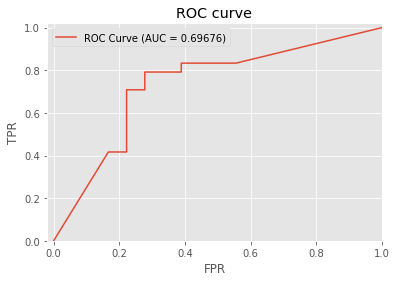

In [109]:
plt.style.use('ggplot')
plt.plot(results['roc_curve']['fpr'],
         results['roc_curve']['tpr'],
         label='ROC Curve (AUC = %0.5f)' %results['auc'])

plt.xlim([-0.02, 1.0])
plt.ylim([0., 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

In [110]:
!mkdir datasets
!mkdir ./datasets/enron
!wget -O ./datasets/enron/enron_mail_20150507.tar.gz https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
!tar -zxvf ./datasets/enron/enron_mail_20150507.tar.gz -C ./datasets/enron/
!ls ./datasets/enron

Streaming output truncated to the last 5000 lines.
maildir/campbell-l/all_documents/1572.
maildir/campbell-l/all_documents/759.
maildir/campbell-l/all_documents/538.
maildir/campbell-l/all_documents/876.
maildir/campbell-l/all_documents/321.
maildir/campbell-l/all_documents/990.
maildir/campbell-l/all_documents/1842.
maildir/campbell-l/all_documents/1460.
maildir/campbell-l/all_documents/1840.
maildir/campbell-l/all_documents/274.
maildir/campbell-l/all_documents/448.
maildir/campbell-l/all_documents/1692.
maildir/campbell-l/all_documents/400.
maildir/campbell-l/all_documents/224.
maildir/campbell-l/all_documents/188.
maildir/campbell-l/all_documents/1670.
maildir/campbell-l/all_documents/1678.
maildir/campbell-l/all_documents/706.
maildir/campbell-l/all_documents/254.
maildir/campbell-l/all_documents/1429.
maildir/campbell-l/all_documents/1704.
maildir/campbell-l/all_documents/529.
maildir/campbell-l/all_documents/1039.
maildir/campbell-l/all_documents/1694.
maildir/campbell-l/all_doc

In [111]:
# Parsing the Enron dataset. The code may miss some of the links
import os, re
from glob import glob
from tqdm import tqdm_notebook as tqdm 

enron_data_set_path = "./datasets/enron/maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"{enron_data_set_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

g = nx.DiGraph()    

Found 99279 files


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/99279 [00:00<?, ?it/s]

In [112]:
g = nx.DiGraph()
g.add_edges_from(links)
print(nx.info(g))

DiGraph with 18590 nodes and 32392 edges


In [ ]:
# Use three different centrality algorithms to identify managers at Enron.

# 1.  community centerality

from networkx.algorithms.community import greedy_modularity_communities
cc = greedy_modularity_communities(g.to_undirected())

# add the community each node belong to
for i in range(len(cc)):
    c = cc[i]
    if len(c) < 2:
        continue # skip this community
    for n in c:
        g.nodes[n]['community'] = i 

node_communities_num_dict = {}
for v in g.nodes():
    connected_communities = [g.nodes[u]['community'] for u in g.neighbors(v) if 'community' in g.nodes[u]]
    node_communities_num_dict[v] = len(set(connected_communities))



In [118]:
# Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks 
# 1.  community centerality
cc_employees = sorted(node_communities_num_dict.items(), key=operator.itemgetter(1), reverse=True)
print("precision@10",cc_employees[:10] )

precision@10 [('jeff.dasovich@enron.com', 15), ('elizabeth.sager@enron.com', 14), ('sara.shackleton@enron.com', 14), ('mark.haedicke@enron.com', 14), ('sally.beck@enron.com', 13), ('tana.jones@enron.com', 13), ('susan.scott@enron.com', 13), ('benjamin.rogers@enron.com', 13), ('richard.sanders@enron.com', 13), ('mark.taylor@enron.com', 13)]


In [114]:
# 2. degree centerality

import operator

d_employees = sorted(dict(g.degree()).items(), key=operator.itemgetter(1), reverse=True)
print("precision@10",d_employees[:10] )

[('jeff.dasovich@enron.com', 683),
 ('sara.shackleton@enron.com', 641),
 ('tana.jones@enron.com', 584),
 ('gerald.nemec@enron.com', 534),
 ('kay.mann@enron.com', 471),
 ('kenneth.lay@enron.com', 466),
 ('vince.kaminski@enron.com', 434),
 ('debra.perlingiere@enron.com', 420),
 ('sally.beck@enron.com', 369),
 ('jeff.skilling@enron.com', 363)]

In [ ]:
# 3. closeness centerality
all_averages = dict()
for node in g.nodes():
   paths = nx.single_source_shortest_path(g, node)
   num_paths = len(paths)
   agg_length = 0

   for lp in paths.values():
     agg_length += len(lp)

   avg_short_path = agg_length/num_paths
   all_averages[node] = avg_short_path


In [117]:
closeness_c = sorted(all_averages.items(), key=operator.itemgetter(1), reverse=True)
print("precision@10",closeness_c[:10] )

precision@10 [('rawsons4@aol.com', 12.195409908418846), ('kelmo3@hotmail.com', 12.195409908418846), ('nwarren@hotmail.com', 12.195409908418846), ('9099632747@airmessage.net', 12.195409908418846), ('westdesksupport@enron.com', 12.195409908418846), ('garrett@jobmenu.com', 12.194285083848191), ('cgallegos@apx.com', 11.198058038177203), ('kourtneynelson@hotmail.com', 11.197947699437272), ('ryan.slinger@enron.com', 11.196645332156256), ('john.anderson@enron.com', 10.199624806885897)]


In [154]:
total = []
total.extend(d_employees[:10])
total.extend(closeness_c[:10])
total.extend(cc_employees[:10])
_tdict = dict(total)
_sorted = sorted(_tdict.items(), key=operator.itemgetter(1), reverse=True)
_sorted = _sorted[:10]
_sorted

[('gerald.nemec@enron.com', 534),
 ('kay.mann@enron.com', 471),
 ('kenneth.lay@enron.com', 466),
 ('vince.kaminski@enron.com', 434),
 ('debra.perlingiere@enron.com', 420),
 ('jeff.skilling@enron.com', 363),
 ('jeff.dasovich@enron.com', 15),
 ('sara.shackleton@enron.com', 14),
 ('elizabeth.sager@enron.com', 14),
 ('mark.haedicke@enron.com', 14)]

In [168]:
print("top ten of each measure")
keys = dict(_sorted).keys()
keys

top ten of each measure


dict_keys(['gerald.nemec@enron.com', 'kay.mann@enron.com', 'kenneth.lay@enron.com', 'vince.kaminski@enron.com', 'debra.perlingiere@enron.com', 'jeff.skilling@enron.com', 'jeff.dasovich@enron.com', 'sara.shackleton@enron.com', 'elizabeth.sager@enron.com', 'mark.haedicke@enron.com'])

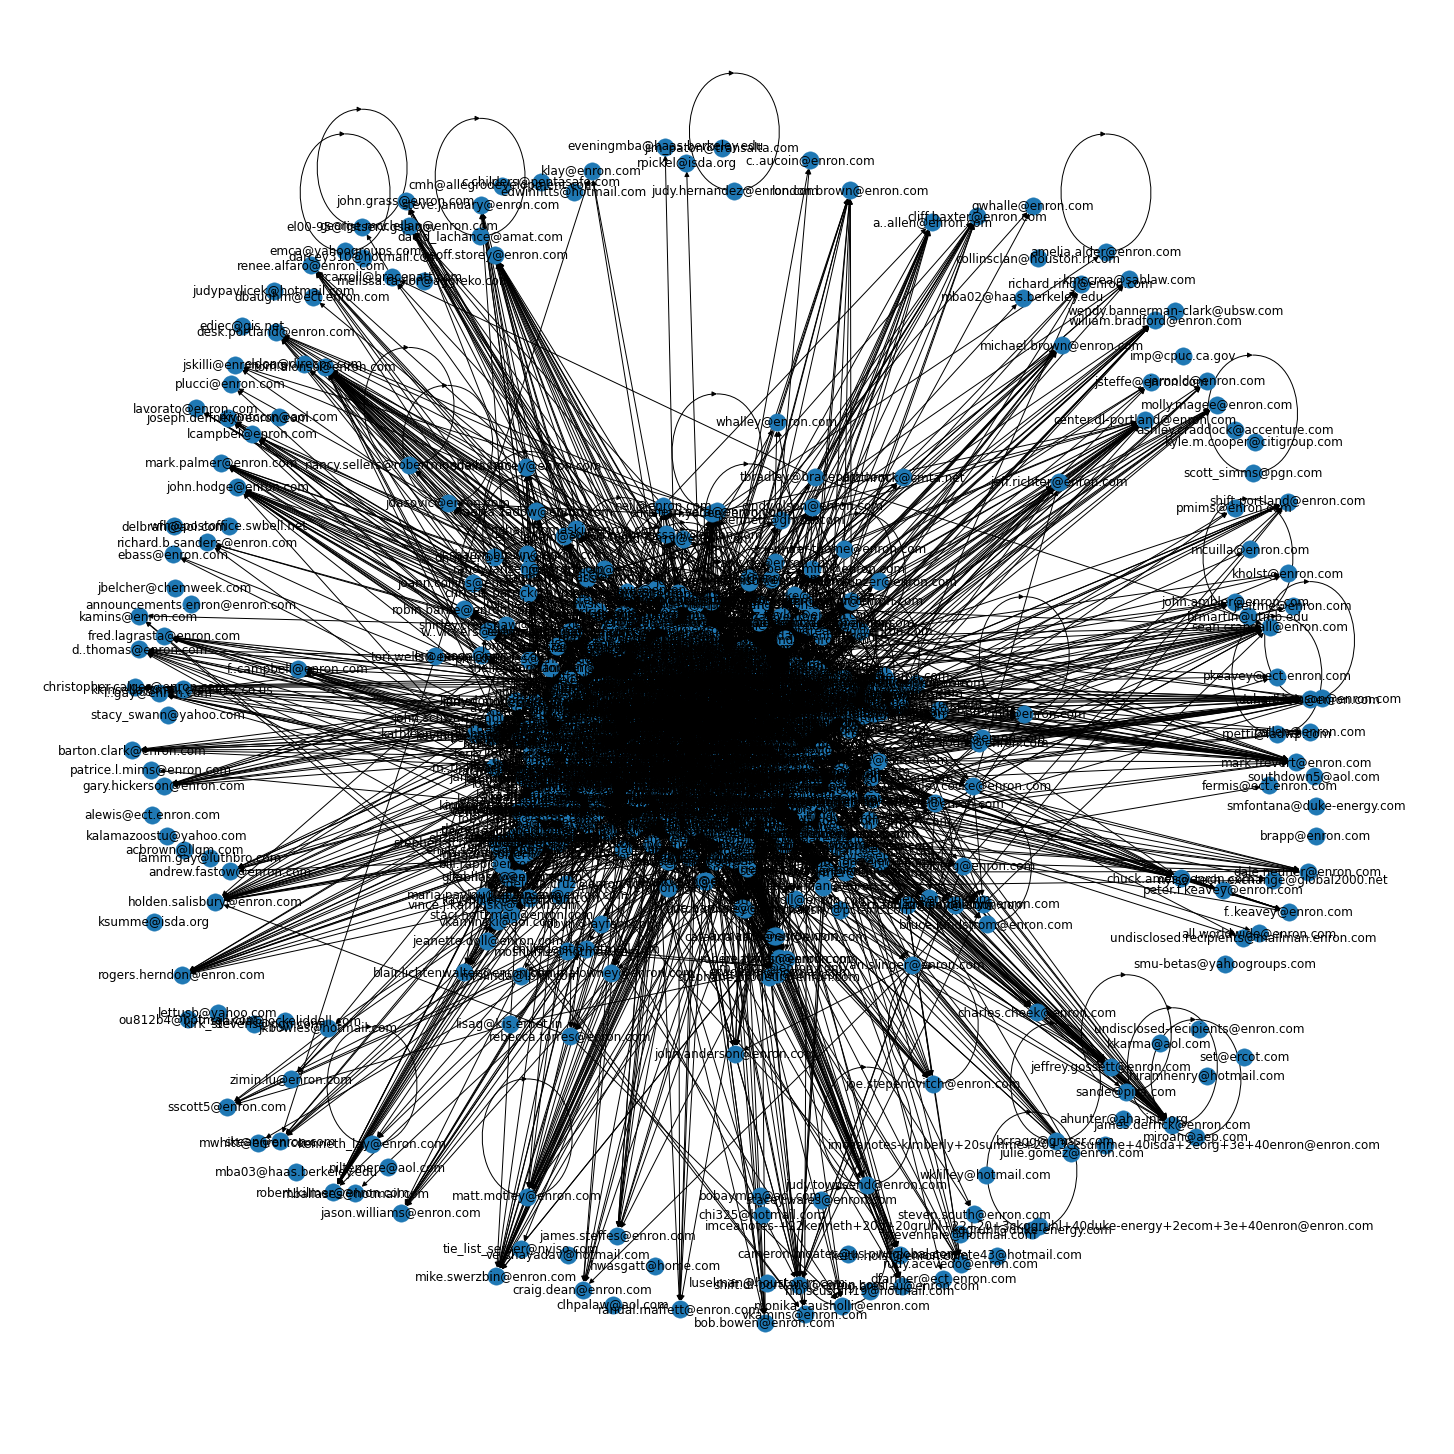

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Draw the network
l = [n for n,degree in dict(g.degree()).items() if degree > 10]
h = g.subgraph(l)
plt.figure(figsize=(20,20))
nx.draw_spring(h,  with_labels=True)





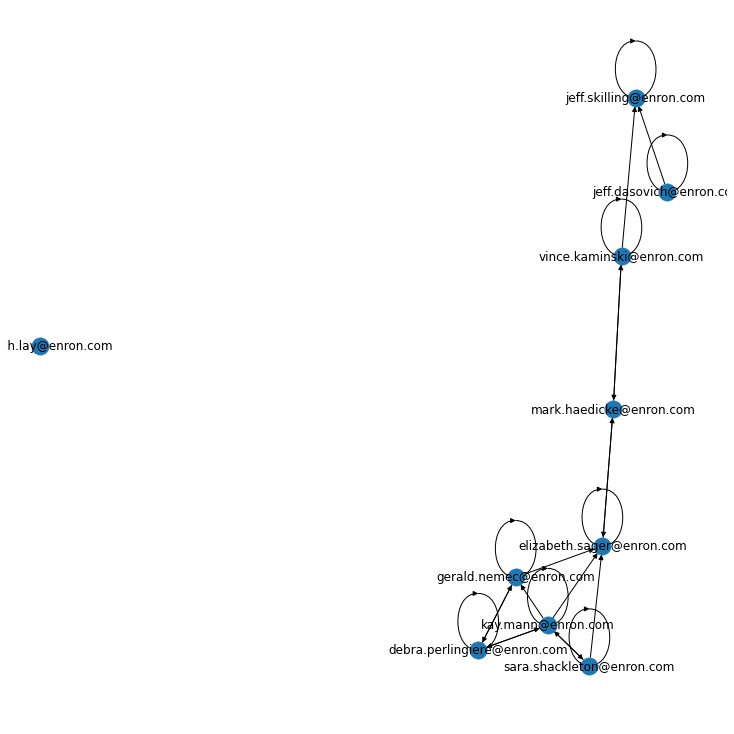

In [186]:

# Visualize top 10
plt.figure(figsize=(10,10))
h = g.subgraph(keys)
nx.draw_spring(h, with_labels=True)

<BarContainer object of 20 artists>

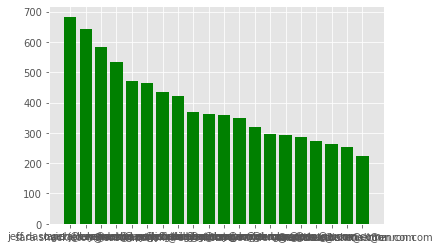

In [179]:
# Visualize one of the centrality measures
myDictionary = dict(d_employees[:20])
plt.bar(myDictionary.keys(), myDictionary.values(), color='g')
